In [1]:
# load required libraries
library(dplyr)
library(ggplot2)
library(MatchIt)
library(stringr)
library(stringi)
library(plm)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'MatchIt' was built under R version 3.6.2"
Attaching package: 'plm'

The following objects are masked from 'package:dplyr':

    between, lag, lead



In [2]:
setwd("C:/Users/HP PC/Desktop/Classes/Spring/Causal Inference/Project")
data = read.csv('steam.csv', header = T, sep = ",", stringsAsFactors = F)

**Hypothesis:** Games being released between June to August are more successful <br>
**Success Criteria:** Games are sold more <br>
**Treatment Variable:** Month of release <br>

In [33]:
## Data exploration and processing ##
## (considering the top three publishers assuming they would have a strategy of launching games that our management wants to understand)
data_filtered = data %>% 
  mutate(treat = ifelse(substr(release_date, 4, 5) == "10"  |
                          substr(release_date, 4, 5) == "11" |
                          substr(release_date, 4, 5) == "12", 1, 0), 
         avg_owners = (min_owners+max_owners)/2,
         action = ifelse(str_detect(tolower(genres), 'action'), 1, 0),
         strategy = ifelse(str_detect(tolower(genres), 'strategy'), 1, 0),
         adventure = ifelse(str_detect(tolower(genres), 'adventure'), 1, 0),
         multi_player = ifelse(str_detect(tolower(categories), 'multi-player'), 1, 0)) %>%
  filter(str_detect(publisher, "Ubisoft") | 
         str_detect(publisher, "Strategy First") | 
         str_detect(publisher, "Big Fish Games")) %>%
  filter(min_owners < 5000000 & max_owners < 10000000) %>%  # removing outliers from data
  select(appid,
         treat,
         avg_owners,
         action,
         strategy,
         adventure,
         multi_player,
         achievements, 
         positive_ratings, 
         negative_ratings, 
         average_playtime,
         median_playtime,
         avg_owners,
         price) 

In [34]:
top_n(data_filtered, 5)

Selecting by price


appid,treat,avg_owners,action,strategy,adventure,multi_player,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
447040,1,750000,1,0,1,0,0,20905,5366,1231,1342,49.99
488790,1,350000,0,0,0,0,35,4840,2017,932,976,49.99
552520,0,750000,1,0,1,1,0,23373,11081,1869,1694,49.99
582160,1,1500000,1,0,1,0,67,31644,6007,2908,3143,49.99
646910,0,350000,1,0,0,1,34,4030,3916,2029,1685,49.99
812140,1,1500000,1,0,1,0,82,20771,4528,3151,3581,49.99


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


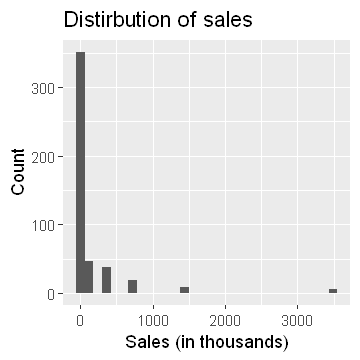

In [35]:
# look at the distribution of number of owners per game before matching
options(repr.plot.width=4, repr.plot.height=4)

options(repr.plot.width=3, repr.plot.height=3)
ggplot(data_filtered, aes(x=avg_owners/1000)) + 
    geom_histogram() +
    ggtitle('Distirbution of sales') +
    xlab('Sales (in thousands)') +
    ylab('Count')

In [36]:
# number of treatment and control units in the datset
nrow(unique(data_filtered %>% filter(treat == 1) %>% select(appid))) 
nrow(unique(data_filtered %>% filter(treat == 0) %>% select(appid)))

[1] 96

[1] 372

## Propensity Score Matching

**Assumption:** <br>
1. We observe all the confounds that matter <br>

In [37]:
# check covariance balancing avg owners before matching
t.test(avg_owners ~ treat, data = data_filtered)


	Welch Two Sample t-test

data:  avg_owners by treat
t = -2.1141, df = 125.97, p-value = 0.03648
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -234104.0   -7727.3
sample estimates:
mean in group 0 mean in group 1 
       121532.3        242447.9 


In [49]:
options(repr.plot.width=3, repr.plot.height=3)
price_before <-ggplot(data_filtered, aes(x=as.factor(treat), y=mean(price))) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Price') + ggtitle('Before Matching')

prate_before <-ggplot(data_filtered, aes(x=as.factor(treat), y=positive_ratings/1000)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Positive Rating (1000s)') + ggtitle('Before Matching')

nrate_before <-ggplot(data_filtered, aes(x=as.factor(treat), y=negative_ratings/ 1000)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Negative Rating (1000s)') + ggtitle('Before Matching')

achievements_before <-ggplot(data_filtered, aes(x=as.factor(treat), y=achievements)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Achievements') + ggtitle('Before Matching')

average_playtime_before <-ggplot(data_filtered, aes(x=as.factor(treat), y=average_playtime)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('average_playtime') + ggtitle('Before Matching')

average_owners_before <-ggplot(data_filtered, aes(x=as.factor(treat), y=avg_owners/1000)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('average owners (1000s)') + ggtitle('Before Matching')

In [39]:
# Calculate statistical power
## Management wants to know with at least 90% confidence if launching a game between October and Decmeber increase sales by 20%.
power.t.test(n=NULL,type=c("two.sample"),power=0.8,sig.level=0.1,delta=0.3)

power.t.test(n=85,type=c("two.sample"),power=0.8,sig.level=0.1,delta=NULL)


     Two-sample t test power calculation 

              n = 138.0715
          delta = 0.3
             sd = 1
      sig.level = 0.1
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group



     Two-sample t test power calculation 

              n = 85
          delta = 0.382954
             sd = 1
      sig.level = 0.1
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


Here we are assuming that month of release only depends on the price. However, that may not be the case. It could depend on a lot of other factors as well like the features of the game and publisher 


Call:
glm(formula = treat ~ price + as.factor(multi_player) + positive_ratings + 
    negative_ratings + achievements + average_playtime, family = "binomial", 
    data = data_filtered)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8665  -0.6413  -0.6215  -0.6105   1.8932  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.635e+00  1.804e-01  -9.062   <2e-16 ***
price                     1.265e-02  1.590e-02   0.796   0.4263    
as.factor(multi_player)1  1.269e-01  3.243e-01   0.391   0.6956    
positive_ratings          5.795e-05  3.733e-05   1.552   0.1205    
negative_ratings         -1.156e-04  1.013e-04  -1.141   0.2537    
achievements              1.578e-02  8.632e-03   1.828   0.0675 .  
average_playtime          8.745e-05  1.419e-04   0.616   0.5377    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null devia

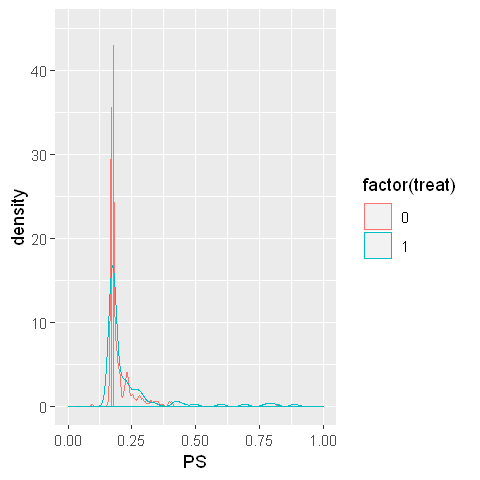

In [40]:
# Look at the propensity score distribution before matching
ps_model = glm(treat ~ price + 
               as.factor(multi_player) +
               positive_ratings +
               negative_ratings +
               achievements +
               average_playtime, data = data_filtered, family = "binomial")
summary(ps_model)
data_filtered$PS = ps_model$fitted.values

options(repr.plot.width=4, repr.plot.height=4)
ggplot(data_filtered, aes(x=PS, color = factor(treat))) +
  geom_density() + xlim(0, 1) + ylim(0, 45) 

In [41]:
# perform matching
# without replacement
match_output <- matchit(treat ~ price + positive_ratings + negative_ratings + achievements + average_playtime, data = data_filtered, 
                        method = "nearest", distance = "logit", caliper = 0.1, replace = F, ratio = 1)

summary(match_output)
data_match = match.data(match_output)


Call:
matchit(formula = treat ~ price + positive_ratings + negative_ratings + 
    achievements + average_playtime, data = data_filtered, method = "nearest", 
    distance = "logit", caliper = 0.1, replace = F, ratio = 1)

Summary of balance for all data:
                 Means Treated Means Control SD Control Mean Diff eQQ Med
distance                0.2374        0.1968     0.0536    0.0405  0.0038
price                  11.6734        8.9508     7.6109    2.7226  0.4500
positive_ratings     2582.0729      998.9543  4448.1105 1583.1186  3.0000
negative_ratings      644.0938      355.0511  2096.4954  289.0427  1.0000
achievements            7.8438        2.6747     9.2395    5.1690  0.0000
average_playtime      398.0729      172.3414   720.6430  225.7315  0.0000
                  eQQ Mean    eQQ Max
distance            0.0372     0.4383
price               2.6098    16.0000
positive_ratings 1448.5938 16098.0000
negative_ratings  587.6458 18566.0000
achievements        4.8646   128.00

In [42]:
# Covariance balance
t.test(avg_owners ~ treat, data = data_match)


	Welch Two Sample t-test

data:  avg_owners by treat
t = -0.13193, df = 158.91, p-value = 0.8952
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -122562.3  107213.5
sample estimates:
mean in group 0 mean in group 1 
       140174.4        147848.8 


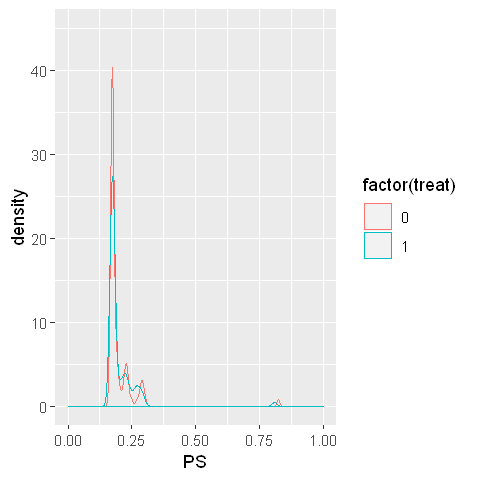

In [43]:
ggplot(data_match, aes(x=PS, color = factor(treat))) +
  geom_density() + xlim(0, 1) + ylim(0, 45) 

In [44]:
# with replacement
match_output <- matchit(treat ~ price + action + adventure + strategy + multi_player
                        , data = data_filtered, 
                        method = "nearest", distance = "logit", caliper = 0.1, replace = T, ratio = 1)

In [51]:
options(repr.plot.width=3, repr.plot.height=3)
price_after <-ggplot(data_match, aes(x=as.factor(treat), y=mean(price))) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Price') + ggtitle('After Matching')

prate_after <-ggplot(data_match, aes(x=as.factor(treat), y=positive_ratings/ 1000)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Positive Rating (1000s)') + ggtitle('After Matching')

nrate_after <-ggplot(data_match, aes(x=as.factor(treat), y=negative_ratings/ 1000)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Negative Rating (1000s)') + ggtitle('After Matching')

achievements_after <-ggplot(data_match, aes(x=as.factor(treat), y=achievements)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('Achievements') + ggtitle('After Matching')

average_playtime_after <-ggplot(data_match, aes(x=as.factor(treat), y=average_playtime)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('average_playtime') + ggtitle('After Matching')

average_owners_after <-ggplot(data_match, aes(x=as.factor(treat), y=avg_owners/1000)) +
  geom_bar(stat="identity")+theme_minimal() +
  xlab('Treatment') + ylab('average owners (1000s)') + ggtitle('After Matching')

In [16]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

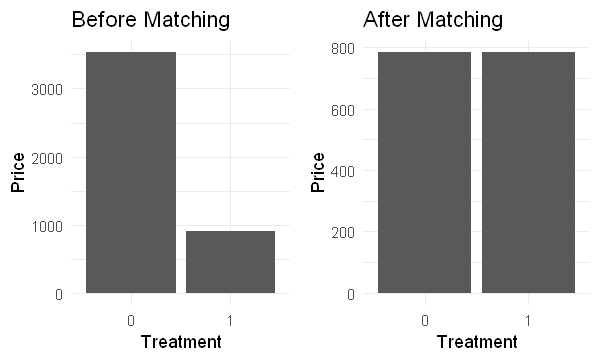

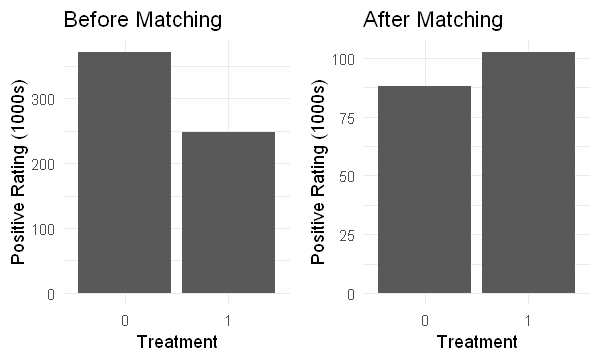

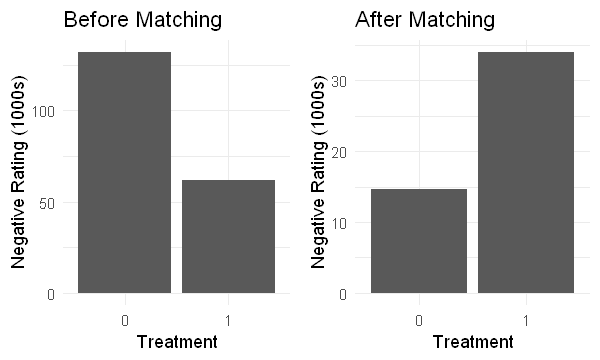

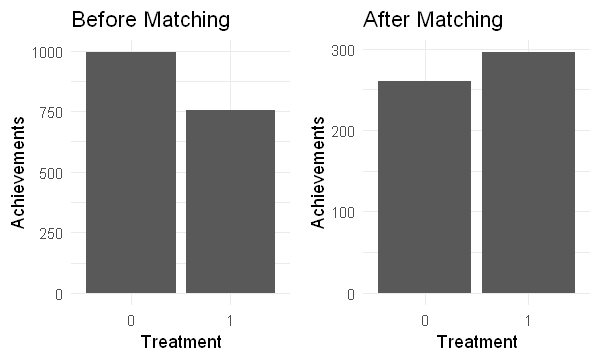

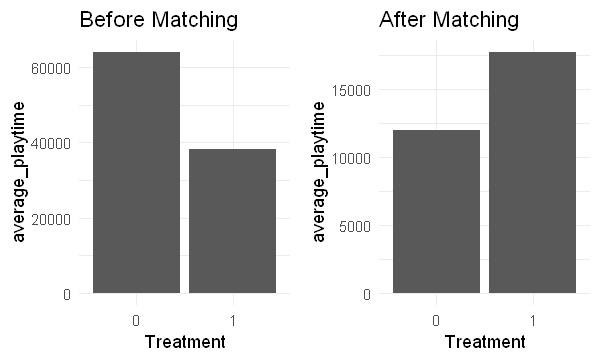

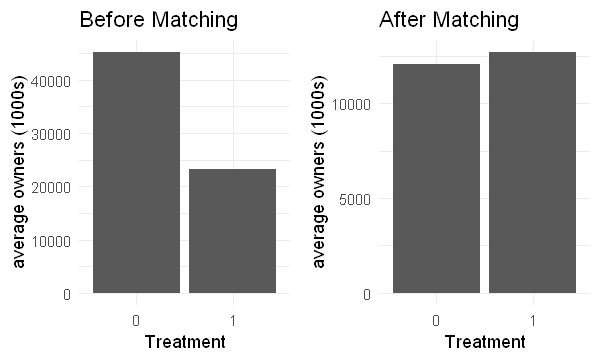

In [52]:
options(repr.plot.width=5, repr.plot.height=3)
multiplot(price_before, price_after, cols = 2)
multiplot(prate_before, prate_after, cols = 2)
multiplot(nrate_before, nrate_after, cols = 2)
multiplot(achievements_before, achievements_after, cols = 2)
multiplot(average_playtime_before, average_playtime_after, cols = 2)
multiplot(average_owners_before, average_owners_after, cols = 2)

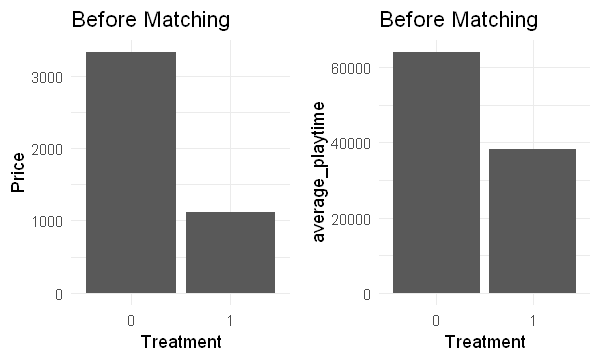

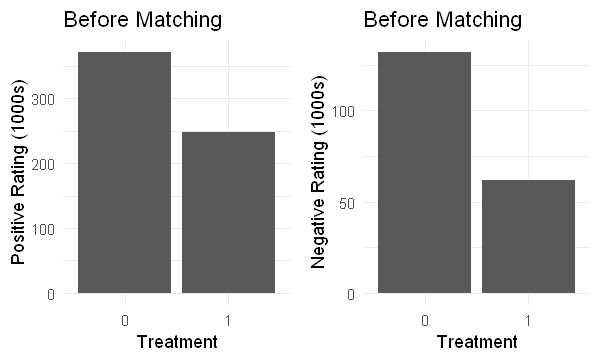

In [18]:
multiplot(price_before, average_playtime_before, cols = 2)
multiplot(prate_before, nrate_before, cols = 2)


	Welch Two Sample t-test

data:  avg_owners by treat
t = -0.18754, df = 158.07, p-value = 0.8515
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -126713.4  104736.6
sample estimates:
mean in group 0 mean in group 1 
       136860.5        147848.8 


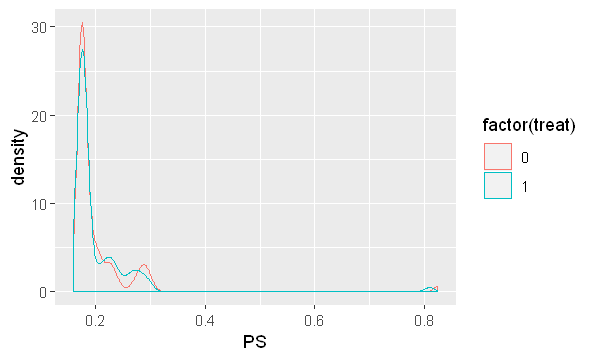

In [19]:
# Covariance balance
t.test(avg_owners ~ treat, data = data_match)
ggplot(data_match, aes(x=PS, color = factor(treat))) +
  geom_density()

In [20]:
# without matching
summary(lm(log(avg_owners+1) ~ treat, data = data_filtered))


Call:
lm(formula = log(avg_owners + 1) ~ treat, data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3214 -0.8782 -0.8782  0.4542  4.9796 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.08869    0.08026 125.705   <2e-16 ***
treat        0.44311    0.17720   2.501   0.0127 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.548 on 466 degrees of freedom
Multiple R-squared:  0.01324,	Adjusted R-squared:  0.01112 
F-statistic: 6.253 on 1 and 466 DF,  p-value: 0.01274


In [21]:
# with matching
summary(lm(log(avg_owners+1) ~ treat, data = data_filtered %>%
             filter(appid %in% data_match$appid)))


Call:
lm(formula = log(avg_owners + 1) ~ treat, data = data_filtered %>% 
    filter(appid %in% data_match$appid))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0077 -1.0077 -0.8734  0.3793  4.9844 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.0839     0.1702  59.262   <2e-16 ***
treat         0.1342     0.2406   0.558    0.578    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.578 on 170 degrees of freedom
Multiple R-squared:  0.001827,	Adjusted R-squared:  -0.004044 
F-statistic: 0.3112 on 1 and 170 DF,  p-value: 0.5777


#### Sensitivity Check - remaining
Rosenbaum Sensitivity Bound / Test

## Fixed Effects

We want to look at the effect of average playtime on the success of the game. (to justify the outcome of PSM)

In [22]:
## games that were released at least twice
games_with_multiple_release = data %>% 
  mutate(name = tolower(name)) %>%
  group_by(name) %>% summarise(occurrence = n()) %>%
  filter(occurrence > 1) %>% 
  select(name)

In [23]:
## Data exploration and processing ##
data_filtered = data %>% 
  mutate(avg_owners = (min_owners+max_owners)/2) %>%
  filter(tolower(name) %in% games_with_multiple_release$name) %>%
  select(appid,
         name,
         achievements, 
         positive_ratings, 
         negative_ratings, 
         average_playtime,
         price,
         avg_owners) 

In [24]:
# check for correlation btw variables before running regression
cor(data_filtered[3:7], method = c("pearson")) # no significant correlation btw any confounds

,achievements,positive_ratings,negative_ratings,average_playtime,price
achievements,1.0000000000,-0.0003820091,-0.007138967,-0.03633335,-0.07348940
positive_ratings,-0.0003820091,1.0000000000,0.418982733,0.26557232,0.25170135
negative_ratings,-0.0071389668,0.4189827326,1.000000000,0.13023240,0.09278647
average_playtime,-0.0363333523,0.2655723235,0.130232402,1.00000000,0.14570469
price,-0.0734894046,0.2517013512,0.092786472,0.14570469,1.00000000


In [25]:
# naive regression
summary(lm(avg_owners ~ price + 
             positive_ratings + 
             negative_ratings +
             achievements +
             average_playtime, data = data_filtered))


Call:
lm(formula = avg_owners ~ price + positive_ratings + negative_ratings + 
    achievements + average_playtime, data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-119130  -18444  -11641    1883  276949 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      32067.135   6905.435   4.644 8.89e-06 ***
price            -2706.197   1238.147  -2.186   0.0308 *  
positive_ratings    35.088      3.032  11.574  < 2e-16 ***
negative_ratings     8.306     15.138   0.549   0.5842    
achievements       -19.691     34.850  -0.565   0.5731    
average_playtime   260.258     49.278   5.281 5.86e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 52100 on 119 degrees of freedom
Multiple R-squared:  0.6721,	Adjusted R-squared:  0.6583 
F-statistic: 48.78 on 5 and 119 DF,  p-value: < 2.2e-16


In [26]:
# with publisher fixed effects (first differencing)
model_within = plm(avg_owners ~ price + 
                   positive_ratings + 
                   negative_ratings +
                   achievements +
                   average_playtime, data = data_filtered, 
                   effect = "individual",  # effect that does not change (over individual, over time)
                   index = 'name', 
                   model = "fd")

summary(model_within)

Oneway (individual) effect First-Difference Model

Call:
plm(formula = avg_owners ~ price + positive_ratings + negative_ratings + 
    achievements + average_playtime, data = data_filtered, effect = "individual", 
    model = "fd", index = "name")

Unbalanced Panel: n = 83, T = 1-3, N = 125
Observations used in estimation: 42

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-127320.642  -12674.160      20.525   12655.855  165060.541 

Coefficients:
                  Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)      -2240.948   8738.947 -0.2564 0.7990769    
price            -2175.770   2288.544 -0.9507 0.3480847    
positive_ratings   153.035     54.700  2.7977 0.0082131 ** 
negative_ratings   660.740    173.147  3.8161 0.0005138 ***
achievements      -516.140    415.887 -1.2411 0.2226105    
average_playtime    71.715     69.821  1.0271 0.3112125    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    3.1951e+11

On removing the fixed effects of publisher and game properties we see that ratings have a much higher impact on sales

Limitations: <br>
1. Still not taking care of time variant factors <br>
2. Assuming that the publisher and game properties remain the same across years which may not be the case <br>